In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from datetime import datetime

from matplotlib import rc,rcParams

rc('text', usetex=False)
rc('axes', linewidth=2)
rc('font', weight='bold')

import json
import pickle
import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import statsmodels.api as sm

In [2]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import backend as k

In [3]:
file = '../data/data_filtered.pkl'
with open(file, 'rb') as handle:
    data_dict = pickle.load(handle)

In [4]:
data_dict.keys()

dict_keys(['AXISBANK', 'BAJFINANCE', 'BAJAJHLDNG', 'CHOLAFIN', 'HDFCBANK', 'ICICIBANK', 'KOTAKBANK', 'SBIN'])

In [5]:
stocks_under_cosideration = ['BAJAJHLDNG', 'CHOLAFIN']

In [6]:
data_filtered = {}
for stocks in stocks_under_cosideration:
    data_filtered[stocks] = data_dict[stocks]

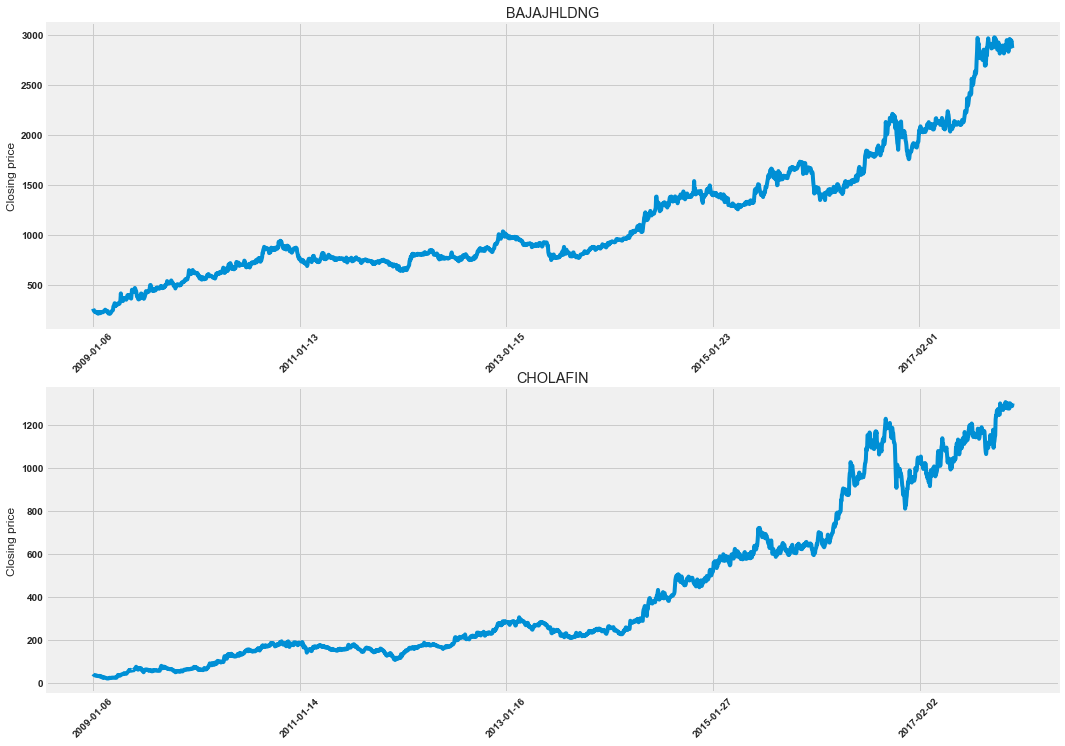

In [7]:
period_start = '2009-01-06'
period_end = '2017-12-31'
final_data = {}
plt.figure(figsize=(15, 10))
#plt.subplots_adjust(top=14, bottom=13) 
for i, company in enumerate(data_filtered.keys(), 1):
    plt.subplot(2,1, i)
    plt.tight_layout()
    data_filtered[company]['nse_closing_price'].loc[period_start:period_end].plot()
    final_data[company] = data_filtered[company].loc[period_start:period_end]
    plt.ylabel('Closing price')
    plt.xlabel(None)
    plt.xticks(rotation = '45')
    plt.title(f"{company}")
plt.show()

## LSTM model for time series forecasting

### BAJAJHLDNG

In [8]:
tensor_length = 5

bajaj_df = final_data['BAJAJHLDNG']['nse_closing_price']
scalar = MinMaxScaler()
bajaj = scalar.fit_transform(bajaj_df.values.reshape(-1,1))
train_ratio = 0.9
bajaj_train= bajaj[0:int(len(bajaj)*train_ratio)]
bajaj_test = bajaj[int(len(bajaj)*train_ratio) - tensor_length:]

In [9]:
train_data = bajaj_train
test_data = bajaj_test
#train_data = scaler_train.fit_transform(train_data)
#test_data = scaler_test.fit_transform(test_data)

In [10]:
print('# training data - ', len(train_data))
print('# test data - ', len(test_data))

# training data -  2004
# test data -  228


In [11]:
x_train = []
y_train = []

for i in range(tensor_length, len(train_data)):
    x_train.append(train_data[i-tensor_length:i, 0])
    y_train.append(train_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_test = []
y_test = []
# y_test = bajaj[int(len(bajaj)*train_ratio):]['nse_closing_price'].values
for i in range(tensor_length, len(test_data)):
    x_test.append(test_data[i-tensor_length:i, 0])
    y_test.append(test_data[i])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [12]:
print('train shape - ', x_train.shape)
print('test shape - ', x_test.shape)

train shape -  (1999, 5, 1)
test shape -  (223, 5, 1)


In [13]:
input_layer = keras.layers.Input(shape = (tensor_length, 1), batch_size=1)
#batch_norm = keras.layers.BatchNormalization()(input_layer)
lstm_1 = keras.layers.LSTM(units=16,
                          return_sequences=True,
                          )(input_layer)
lstm_2 = keras.layers.LSTM(units=8,
                          return_sequences=False,
                          )(lstm_1)
dense_1 = keras.layers.Dense(units=4)(lstm_2)
output = keras.layers.Dense(units=1)(dense_1)
bajaj_model = keras.Model(input_layer, output, name = 'LSTM_model')
bajaj_model.summary()

Model: "LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(1, 5, 1)]               0         
_________________________________________________________________
lstm (LSTM)                  (1, 5, 16)                1152      
_________________________________________________________________
lstm_1 (LSTM)                (1, 8)                    800       
_________________________________________________________________
dense (Dense)                (1, 4)                    36        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 1,993
Trainable params: 1,993
Non-trainable params: 0
_________________________________________________________________


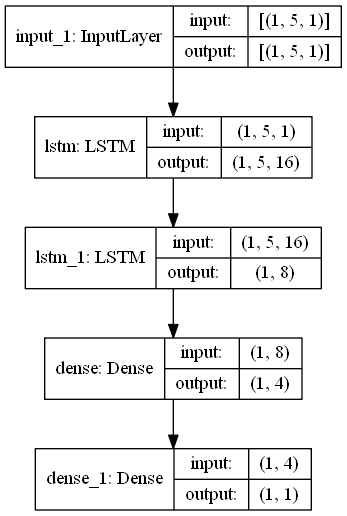

In [31]:
keras.utils.plot_model(bajaj_model,show_shapes=True)

In [14]:
bajaj_predictions = list()
bajaj_model.compile(loss=keras.losses.MeanSquaredError(), optimizer = keras.optimizers.Adam(lr = 0.0003))

for i in range(len(x_test[:50])-1):
    bajaj_model.fit(x_train, y_train, batch_size=1,epochs =1)
    #print(x_test.shape)
    #print(y_train.shape)
    output = bajaj_model.predict(x_test[i].reshape(1,-1,1))
    yhat = output[0]
    bajaj_predictions.append(yhat)
    obs_x = np.expand_dims(x_test[i], axis = 0)
    obs_y = y_test[i]
    x_train = np.append(x_train, obs_x, axis = 0)
    y_train = np.append(y_train, obs_y)
    print(yhat-obs_y)

Train on 1999 samples
1999/1999 [==============================] - 15s 8ms/sample - loss: 0.0070
[-0.00328387]
Train on 2000 samples
2000/2000 [==============================] - 9s 4ms/sample - loss: 2.0192e-04
[-0.01519407]
Train on 2001 samples
2001/2001 [==============================] - 9s 4ms/sample - loss: 1.8823e-04
[-0.00787057]
Train on 2002 samples
2002/2002 [==============================] - 8s 4ms/sample - loss: 1.8526e-04
[-0.00810707]
Train on 2003 samples
2003/2003 [==============================] - 9s 4ms/sample - loss: 1.8152e-04
[4.11372109e-05]
Train on 2004 samples
2004/2004 [==============================] - 9s 5ms/sample - loss: 1.7233e-04
[-0.00340776]
Train on 2005 samples
2005/2005 [==============================] - 9s 5ms/sample - loss: 1.7136e-04
[-0.00175817]
Train on 2006 samples
2006/2006 [==============================] - 9s 5ms/sample - loss: 1.6658e-04
[-0.01680994]
Train on 2007 samples
2007/2007 [==============================] - 10s 5ms/sample - loss

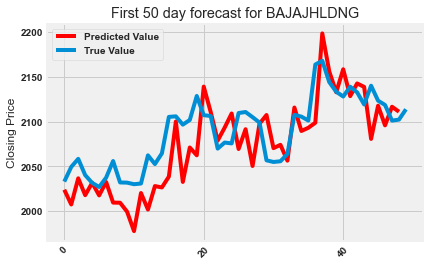

In [30]:
## bajaj_predictions = np.squeeze(scalar.inverse_transform(bajaj_predictions))  # uncomment this line after training the model
plt.title('First 50 day forecast for BAJAJHLDNG')
plt.plot(bajaj_predictions, color = 'r', label = 'Predicted Value')
plt.plot(np.squeeze(scalar.inverse_transform(y_test))[:50], label = 'True Value')
plt.xticks(np.arange(0,len(bajaj_df.iloc[int(len(bajaj_df)*train_ratio):int(len(bajaj_df)*train_ratio) + 50]), 20), rotation = 45)
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [26]:
mse = np.mean((bajaj_predictions - np.squeeze(scalar.inverse_transform(y_test))[:49])**2)
print('Mean Squared Error - ', mse)

1050.6996965490716

### CHOLAFIN

In [38]:
tensor_length = 5

chola_df = final_data['CHOLAFIN']['nse_closing_price']
scalar = MinMaxScaler()
chola = scalar.fit_transform(chola_df.values.reshape(-1,1))
train_ratio = 0.9
chola_train= chola[0:int(len(chola)*train_ratio)]
chola_test = chola[int(len(chola)*train_ratio) - tensor_length:]

In [39]:
train_data = bajaj_train
test_data = bajaj_test

print('# training data - ', len(train_data))
print('# test data - ', len(test_data))

# training data -  2004
# test data -  228


In [40]:
x_train = []
y_train = []

for i in range(tensor_length, len(train_data)):
    x_train.append(train_data[i-tensor_length:i, 0])
    y_train.append(train_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_test = []
y_test = []
# y_test = bajaj[int(len(bajaj)*train_ratio):]['nse_closing_price'].values
for i in range(tensor_length, len(test_data)):
    x_test.append(test_data[i-tensor_length:i, 0])
    y_test.append(test_data[i])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [41]:
print('train shape - ', x_train.shape)
print('test shape - ', x_test.shape)

train shape -  (1999, 5, 1)
test shape -  (223, 5, 1)


In [42]:
input_layer = keras.layers.Input(shape = (tensor_length, 1), batch_size=1)
#batch_norm = keras.layers.BatchNormalization()(input_layer)
lstm_1 = keras.layers.LSTM(units=16,
                          return_sequences=True,
                          )(input_layer)
lstm_2 = keras.layers.LSTM(units=8,
                          return_sequences=False,
                          )(lstm_1)
dense_1 = keras.layers.Dense(units=4)(lstm_2)
output = keras.layers.Dense(units=1)(dense_1)
chola_model = keras.Model(input_layer, output, name = 'LSTM_model')
chola_model.summary()

Model: "LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(1, 5, 1)]               0         
_________________________________________________________________
lstm_4 (LSTM)                (1, 5, 16)                1152      
_________________________________________________________________
lstm_5 (LSTM)                (1, 8)                    800       
_________________________________________________________________
dense_4 (Dense)              (1, 4)                    36        
_________________________________________________________________
dense_5 (Dense)              (1, 1)                    5         
Total params: 1,993
Trainable params: 1,993
Non-trainable params: 0
_________________________________________________________________


In [43]:
chola_predictions = list()
chola_model.compile(loss=keras.losses.MeanSquaredError(), optimizer = keras.optimizers.Adam(lr = 0.0003))

for i in range(len(x_test[:50])-1):
    chola_model.fit(x_train, y_train, batch_size=1,epochs =1)
    #print(x_test.shape)
    #print(y_train.shape)
    output = chola_model.predict(x_test[i].reshape(1,-1,1))
    yhat = output[0]
    chola_predictions.append(yhat)
    obs_x = np.expand_dims(x_test[i], axis = 0)
    obs_y = y_test[i]
    x_train = np.append(x_train, obs_x, axis = 0)
    y_train = np.append(y_train, obs_y)
    print(yhat-obs_y)

Train on 1999 samples
1999/1999 [==============================] - 13s 6ms/sample - loss: 0.0032
[0.00622301]
Train on 2000 samples
2000/2000 [==============================] - 7s 4ms/sample - loss: 1.7333e-04
[-0.01766814]
Train on 2001 samples
2001/2001 [==============================] - 8s 4ms/sample - loss: 1.6580e-04
[-0.01353587]
Train on 2002 samples
2002/2002 [==============================] - 8s 4ms/sample - loss: 1.6855e-04
[0.01304024]
Train on 2003 samples
2003/2003 [==============================] - 8s 4ms/sample - loss: 1.6959e-04
[0.01895441]
Train on 2004 samples
2004/2004 [==============================] - 8s 4ms/sample - loss: 1.5832e-04
[0.00224866]
Train on 2005 samples
2005/2005 [==============================] - 8s 4ms/sample - loss: 1.6182e-04
[-0.01252212]
Train on 2006 samples
2006/2006 [==============================] - 9s 4ms/sample - loss: 1.6197e-04
[0.00575334]
Train on 2007 samples
2007/2007 [==============================] - 8s 4ms/sample - loss: 1.5639e

In [44]:
chola_predictions = np.squeeze(scalar.inverse_transform(chola_predictions))  # uncomment this line after training the model

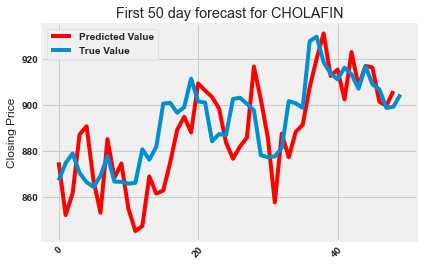

In [46]:
plt.title('First 50 day forecast for CHOLAFIN')
plt.plot(chola_predictions, color = 'r', label = 'Predicted Value')
plt.plot(np.squeeze(scalar.inverse_transform(y_test))[:50], label = 'True Value')
plt.xticks(np.arange(0,len(chola_df.iloc[int(len(chola_df)*train_ratio):int(len(chola_df)*train_ratio) + 50]), 20), rotation = 45)
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [48]:
mse = np.mean((chola_predictions - np.squeeze(scalar.inverse_transform(y_test))[:49])**2)
print('Mean Squared Error - ', mse)

Mean Squared Error -  251.50136381330714
